In [3]:
import yaml
import json
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from dataset_classification import FullMembraneDataset
from transformations_classification import PreprocessFullMembrane, AugmentedFullMembrane
from utils_classification.visualizer import show_membrane, plot_metrics
from model_classification import ClassificationModel
from trainer_classification import TrainerClassification
from inference_classification import run_inference_dataset

# Read arguments from dict and store them as Namespace
with open('config_classification.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)
args = argparse.Namespace(**config_dict) 

for k, v in config_dict.items():
    print(f'{k}: {v}')

dataset_dir: data_classification/
saved_models_dir: saved_models/
kit_id: BTNx
do_validation: 1
use_test_as_validation: 1
shots: 0
device: cpu
seed: 42
batch_size: 16
num_workers: 0
lr: 0.001
weight_decay: 1e-05
step_size: 30
gamma: 0.2
epochs: 10


## Can we crop the zones of all test kits with the same location coordinates?

In [55]:
def resize_image(image, new_height):
    """
    Resize image to a a new height, preserving the original width/height ratio.
    """
    ratio = image.shape[1] / image.shape[0]
    new_width = int(new_height*ratio)
    image = cv2.resize(image, (new_width, new_height))
    return image

In [60]:
# Load membrane paths of all 5 kit tests
kits_paths = ['BTNx/train',
              'Acon_Ab_NEW/membranes', 
              'ACON_Ag/membranes',  
              'DeepBlue_Ag/membranes', 
              'FlowFlex - Comparative Assessment/membranes', 
              'Paramount-Jinwofu_Ag/membranes']

kits_paths = [os.path.join(args.dataset_dir, path) for path in kits_paths]

membranes_paths = []
for i, path in enumerate(kits_paths):
    membrane_filenames = os.listdir(path)
    membranes_paths.append([os.path.join(path, filename) for filename in membrane_filenames])

In [103]:
zones_loc = [0.1, 0.40, 0.60, 0.85]

#### BTNx

BTNx


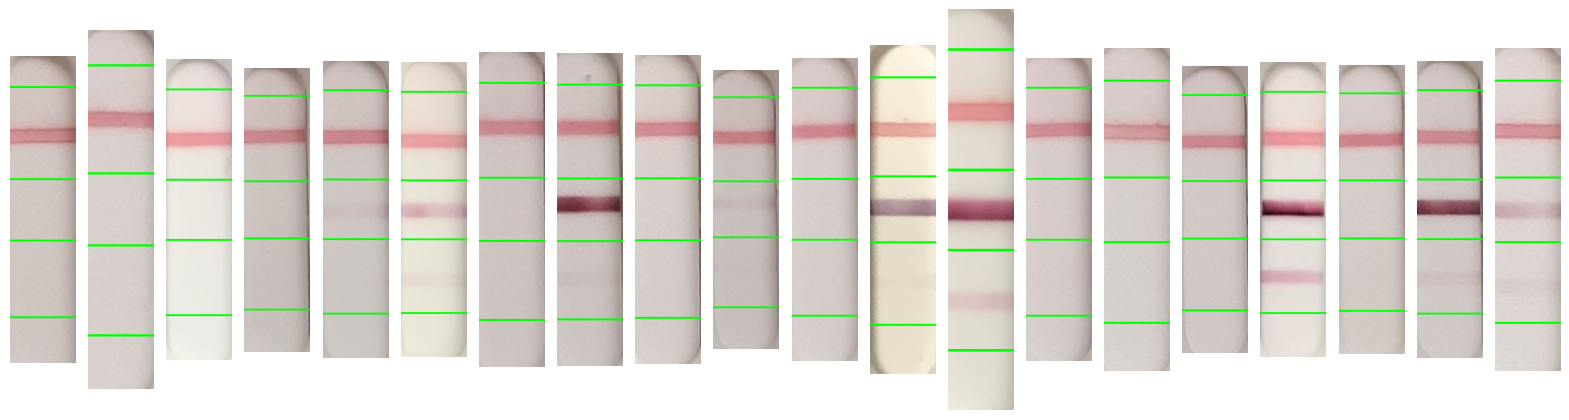

In [104]:
n = 20
height = 480

fig, axs = plt.subplots(1, n, figsize=(n, 10*n))
print('BTNx')

for i in range(n):
    membrane = resize_image(cv2.imread(membranes_paths[0][i]), height)
    
    # Draw green horizontal lines at each cropping location to devide zones
    x1, x2 = 0, membrane.shape[1]
    for loc in zones_loc:
        y = int(loc*height)
        cv2.line(membrane, (x1, y), (x2, y), (0, 255, 0), thickness=2)
    
    axs[i].imshow(membrane[:,:,::-1])
    axs[i].axis('off')
plt.show()

#### Acon_Ab

Acon_Ab


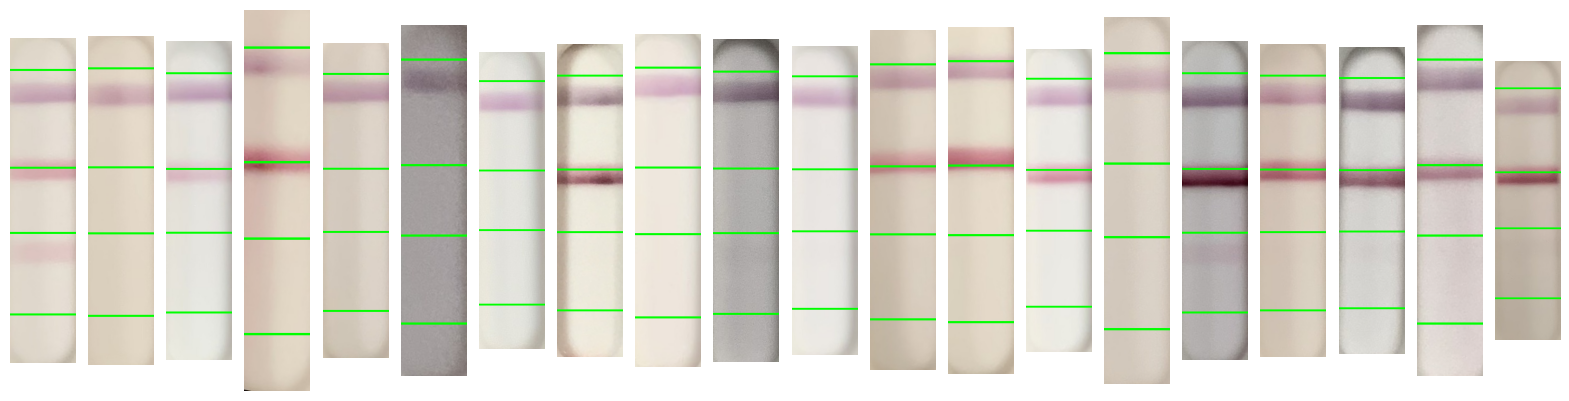

In [106]:
n = 20
height = 480

fig, axs = plt.subplots(1, n, figsize=(n, 10*n))
print('Acon_Ab')

for i in range(n):
    membrane = resize_image(cv2.imread(membranes_paths[1][i]), height)
    
    # Draw green horizontal lines at each cropping location to devide zones
    x1, x2 = 0, membrane.shape[1]
    for loc in zones_loc:
        y = int(loc*height)
        cv2.line(membrane, (x1, y), (x2, y), (0, 255, 0), thickness=2)
    
    axs[i].imshow(membrane[:,:,::-1])
    axs[i].axis('off')
plt.show()

In [28]:
# Load metadata json file
kit_data_file = os.path.join(args.dataset_dir, 'kit_data.json')
with open(kit_data_file) as f:
    kit_data = json.load(f)
    
for k, v in kit_data.items():
    print(k)
    zone_locs = list(v['dimensions']['zones'].values())[1:]
    for loc in zone_locs:
        print(f"y: {loc['y']}, h: {loc['h']}")

BTNx
y: 0.0, h: 0.35
y: 0.35, h: 0.24
y: 0.59, h: 0.22
ACON_Ab
y: 0.05, h: 0.22
y: 0.27, h: 0.26
y: 0.53, h: 0.27
ACON_Ag
y: 0.04, h: 0.51
y: 0.55, h: 0.36
DeepBlue_Ag
y: 0.03, h: 0.42
y: 0.45, h: 0.44
RapidConnect_Ab
y: 0.07, h: 0.32
y: 0.39, h: 0.25
y: 0.64, h: 0.3
Paramount_Ag
y: 0.05, h: 0.43
y: 0.48, h: 0.38
McKendry_S1_Ab
y: 0.16, h: 0.28
y: 0.44, h: 0.26
Quidel_Ag
y: 0.0, h: 0.34
y: 0.34, h: 0.32
Abbot_Binax
y: 0.07, h: 0.4
y: 0.47, h: 0.45
AccessBio_Ag
y: 0.08, h: 0.41
y: 0.5, h: 0.43
Quidel_Ag_tight
y: 0.2, h: 0.11
y: 0.38, h: 0.15
biomedomics
y: 0.0, h: 0.3
y: 0.3, h: 0.25
y: 0.55, h: 0.25
biomedomics_2zones
y: 0.0, h: 0.4
y: 0.4, h: 0.4
oraquick
y: 0.0, h: 0.25
y: 0.3, h: 0.3
maxim
y: 0.0, h: 0.37
y: 0.37, h: 0.29
y: 0.67, h: 0.33
aytu
y: 0.0, h: 0.35
y: 0.35, h: 0.25
y: 0.6, h: 0.34
sd_igg
y: 0.0, h: 0.4
y: 0.56, h: 0.4
abbott
y: 0.0, h: 0.5
y: 0.5, h: 0.5


In [8]:
kit_data

{'BTNx': {'dimensions': {'aspect_ratio': 0.29,
   'membrane': {'x': 0.41, 'y': 0.36, 'w': 0.18, 'h': 0.23},
   'zones': {'n': 3,
    'zone1': {'x': 0.0, 'y': 0.0, 'w': 1.0, 'h': 0.35},
    'zone2': {'x': 0.0, 'y': 0.35, 'w': 1, 'h': 0.24},
    'zone3': {'x': 0.0, 'y': 0.59, 'w': 1, 'h': 0.22}},
   'indicator': {'w': 1.0, 'h': 0.05}},
  'diagnosis_mapping': {'(1, 0, 0)': 0,
   '(1, 0, 1)': 0,
   '(1, 1, 0)': 1,
   '(1, 1, 1)': 1,
   '(0, 0, 0)': 99,
   '(0, 0, 1)': 99,
   '(0, 1, 0)': 99,
   '(0, 1, 1)': 99}},
 'ACON_Ab': {'dimensions': {'aspect_ratio': 0.28,
   'membrane': {'x': 0.42, 'y': 0.35, 'w': 0.16, 'h': 0.21},
   'zones': {'n': 3,
    'zone1': {'x': 0.0, 'y': 0.05, 'w': 1.0, 'h': 0.22},
    'zone2': {'x': 0.0, 'y': 0.27, 'w': 1.0, 'h': 0.26},
    'zone3': {'x': 0.0, 'y': 0.53, 'w': 1.0, 'h': 0.27}},
   'indicator': {'w': 1.0, 'h': 0.07}},
  'diagnosis_mapping': {'(1, 0, 0)': 0,
   '(1, 0, 1)': 1,
   '(1, 1, 0)': 1,
   '(1, 1, 1)': 1,
   '(0, 0, 0)': 99,
   '(0, 0, 1)': 99,
   '

In [19]:
sequences = ['100', '101', '110', '111', '000', '001', '010', '011']
diagnosis_mapping = {'100': 0, '101': 1, '110': 1, '111': 1, '000': 0, '001': 0, '010': 0, '011': 0}

label_file = pd.read_csv(os.path.join(args.dataset_dir, 'BTNx', 'BTNx_labels.csv'), index_col='Sample ID', dtype=str)

In [60]:
ratio = 0.6
filenames_train = []
filenames_test = []

for i, seq in enumerate(sequences):
    # Get filenames with specific zone sequence
    seq_filenames = label_file.index[label_file['Zones'] == seq].tolist()
    
    # Shuffle filenames and split into training and test sets according to ratio
    n_seq_train = int(len(seq_filenames)*ratio)
    np.random.shuffle(seq_filenames)
    filenames_train.extend(seq_filenames[:n_seq_train])
    filenames_test.extend(seq_filenames[n_seq_train:])

In [39]:
filenames_per_sequence = [label_file.index[label_file['Zones'] == seq].tolist() for seq in sequences]
n_sequences = list(map(len, filenames_per_sequence))
n_pos = sum([n_sequences[i] for (i, seq) in enumerate(sequences) if diagnosis_mapping[seq]])
n_neg = sum(n_sequences) - n_pos

In [52]:
label_file.value_counts().tolist()

[375, 218, 29, 15]

N Negative: 375, N Positive: 262


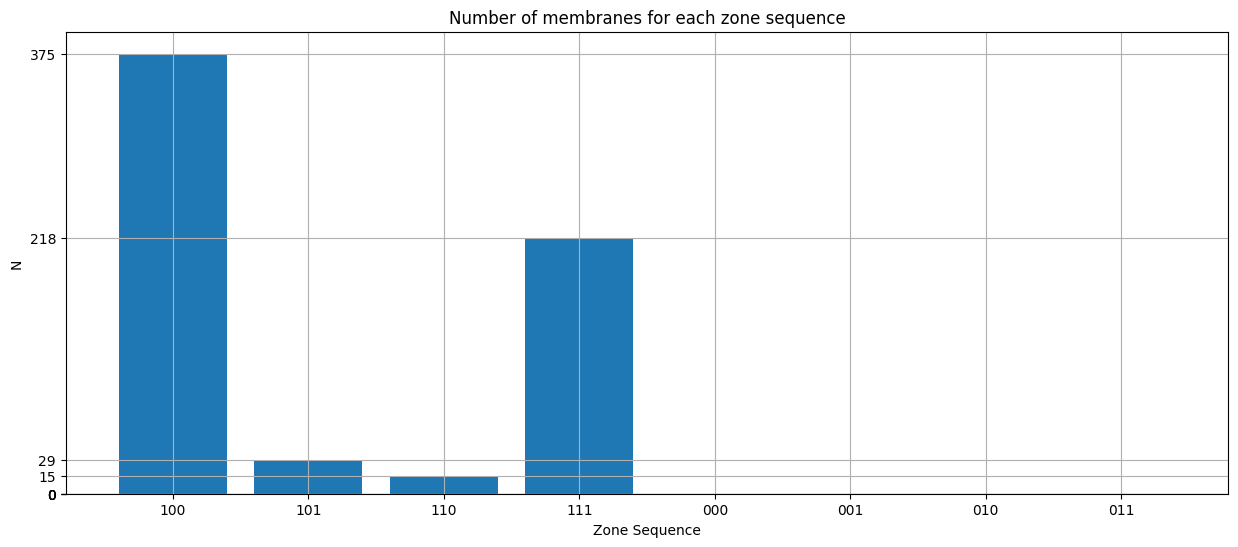

In [41]:
print(f'N Negative: {n_neg}, N Positive: {n_pos}')
plt.figure(figsize=(15, 6))
plt.bar(x=list(map(str, sequences)), height=n_sequences)
plt.title('Number of membranes for each zone sequence')
plt.xlabel('Zone Sequence')
plt.ylabel('N')
plt.yticks(n_sequences)
plt.grid()
plt.show()

In [58]:
range(0, n_)

ValueError: low >= high

In [ ]:
# Determine dataset sizes
ratio = 0.6
n_total = len(label_file)
n_train = int(n_total*train_test_ratio)
n_test = n_total - n_train
print(n_total, n_train, n_test)

In [ ]:
membranes_folder = os.path.join(args.dataset_dir, args.kit_id, 'train)
membrane_filenames = os.listdir(membranes_folder)
self.membrane_paths = [os.path.join(membranes_folder, fname) for fname in membrane_filenames]

# Labels

self.labels = [label_file.loc[fname.replace('.jpg', '')].tolist() for fname in membrane_filenames]

# Map original labels in format [1, 1, 1] to binary, 1 or 0
self.labels = self.labels_to_binary(self.labels)

In [10]:
import numpy as np
from torchvision import transforms

class PreprocessFullMembrane:
    def __init__(self, w=224, h=224):

        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        self.w, self.h = w, h

        # Common resizing transformation
        self.resize = transforms.Resize((self.h, self.w))
        # For data augmentation
        self.augment = None
        # Final common transformation
        self.final_transformation = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(self.mean, self.std)])
            
    def __call__(self, image):

        image = self.resize(image)
        if self.augment:
            image = self.augment(image)
        image = self.final_transformation(image)

        return image

class AugmentedFullMembrane(PreprocessFullMembrane):
    def __init__(self, w=248, h=248):
        super().__init__(w=w, h=h)
        self.augment = transforms.Compose([
                    transforms.RandomCrop((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5)])#,
                    # transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
                    # transforms.GaussianBlur(kernel_size=(1, 9), sigma=(0.1, 5.))])

In [11]:
args.lr = 0.0001
args.weight_decay = 0.0001
args.batch_size = 16
args.num_workers = 0
args.epochs = 10
args.step_size = 11
args.gamma = 0.5

transformation_train = AugmentedFullMembrane()
transformation_val = PreprocessFullMembrane()
trainer = TrainerClassification(args, transformation_train=transformation_train, transformation_val=transformation_val)

Using cpu device
Random seed set as 42
Loading data...
There are 383 images in the BTNx set for train mode
There are 254 images in the BTNx set for test mode


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

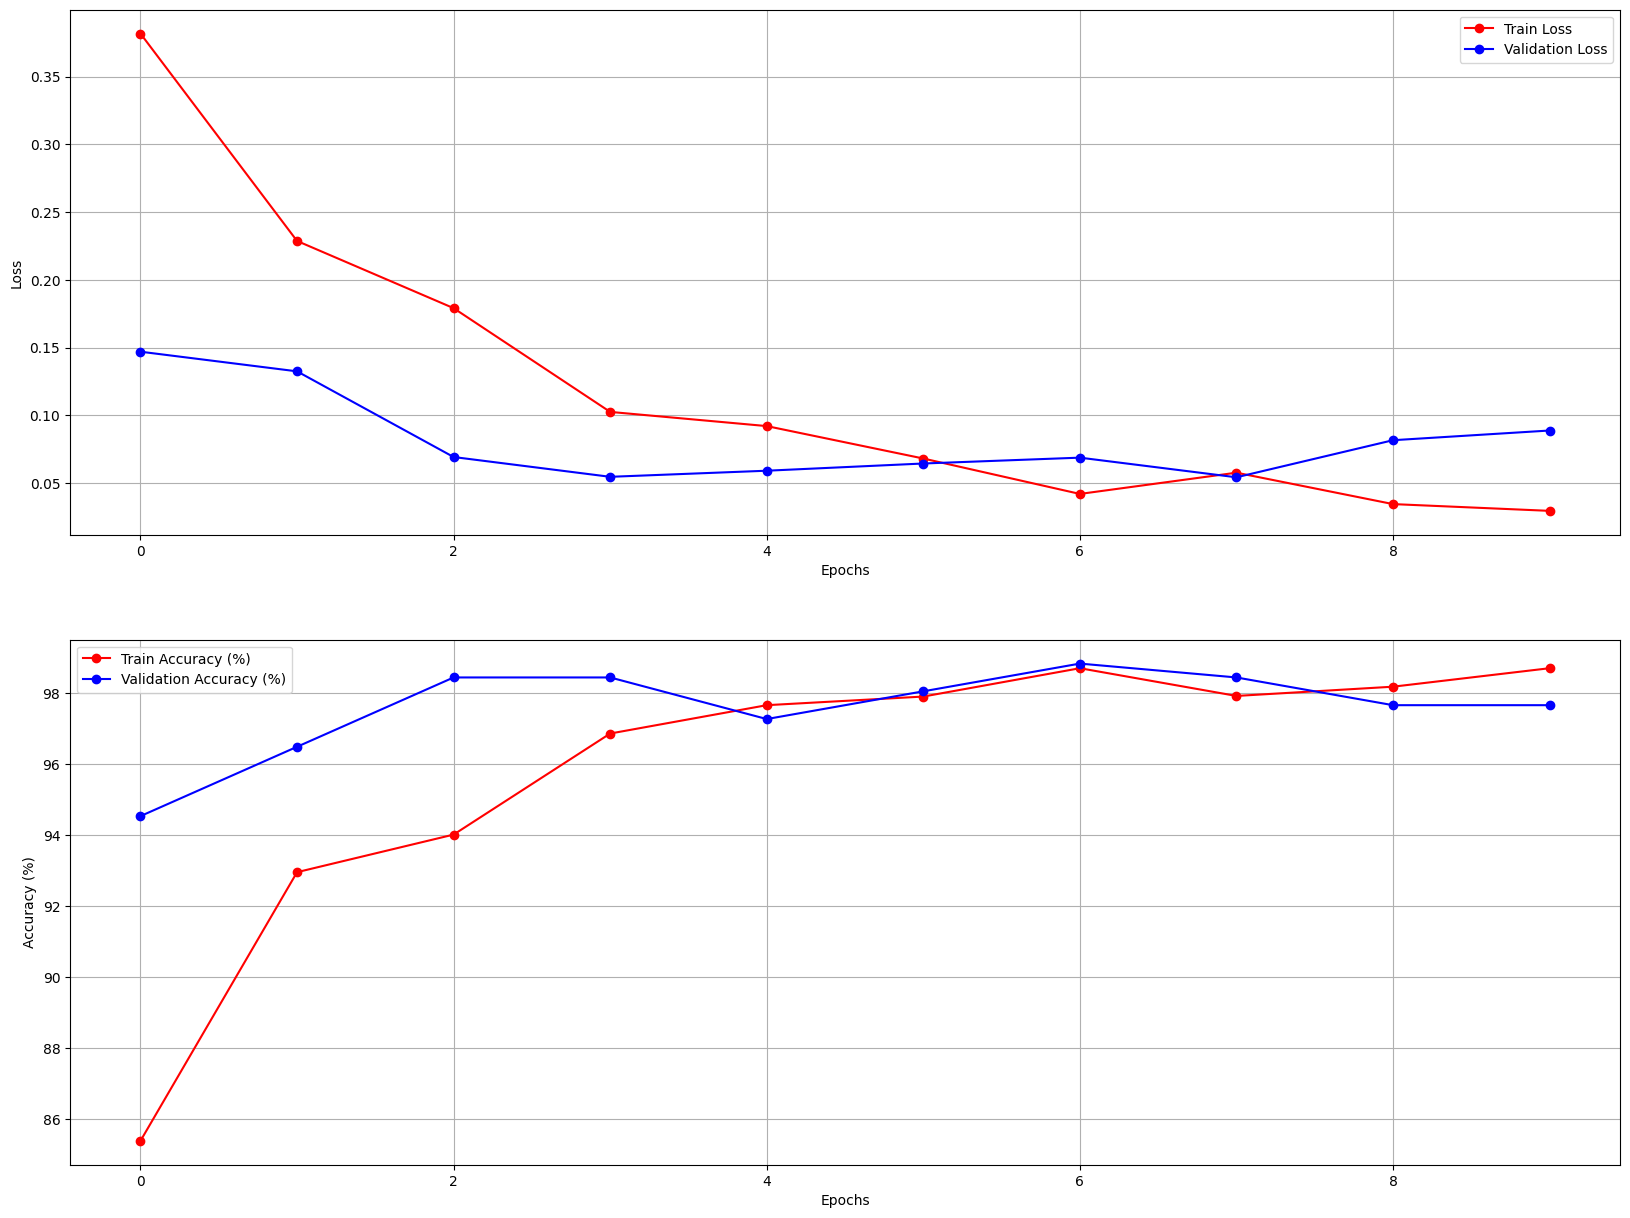

In [12]:
trainer.train(save_bool=False)
trainer.save_txt_file()
plot_metrics(*trainer.get_metrics(), figsize=(20, 15))

## Check missclassified

In [17]:
load_path = os.path.join(args.saved_models_dir, '2024-02-24_16.51.52_best.state')
state = torch.load(load_path, map_location='cpu')
model = ClassificationModel()
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [18]:
transformation = PreprocessFullMembrane()
trainset = FullMembraneDataset(args, set_mode='train', transform=transformation)
testset = FullMembraneDataset(args, set_mode='test', transform=transformation)

outputs_train_df = run_inference_dataset(trainset, model)
outputs_test_df = run_inference_dataset(testset, model)

misclassified_train = outputs_train_df[outputs_train_df['targets']!=outputs_train_df['predictions']]
misclassified_test = outputs_test_df[outputs_test_df['targets']!=outputs_test_df['predictions']]
misclassified_train_ndx = misclassified_train.index.tolist()
misclassified_test_ndx = misclassified_test.index.tolist()

n_wrong_train = len(misclassified_train)
n_wrong_test = len(misclassified_test)
print(f'Number of train examples missclassified: {n_wrong_train}')
print(f'Number of test examples missclassified: {n_wrong_test}')

There are 383 images in the BTNx set for train mode
There are 254 images in the BTNx set for test mode
Running Inference...
Running Inference...
Number of train examples missclassified: 0
Number of test examples missclassified: 3


torch.Size([3, 224, 224]) tensor([1.])


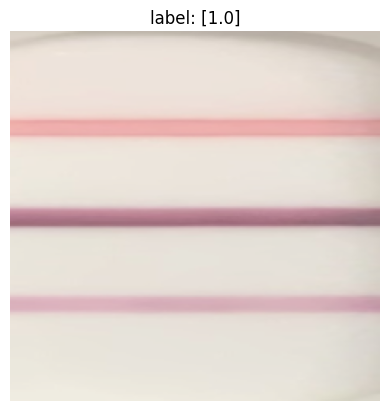

In [33]:
idx = misclassified_test_ndx[0]
membrane, label = trainset[idx]
print(membrane.shape, label)
show_membrane(membrane, label, transformation.mean, transformation.std)

In [544]:
from PIL import Image
from torchvision import transforms

transformation = AugmentedFullMembrane(w=248, h=248)
# transformation = transforms.Compose([transforms.Resize((224, 244)), transforms.GaussianBlur(kernel_size=(1, 9), sigma=(0.1, 5.))])
# transformation = transforms.Resize((224, 244))

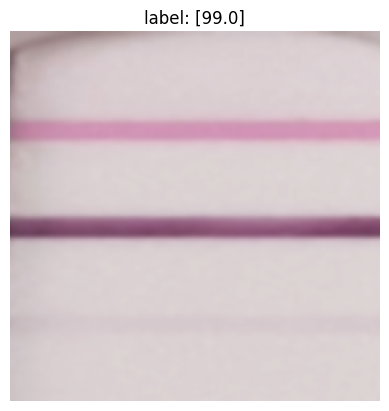

In [603]:
image = Image.open(trainset.membrane_paths[18])
image_t = transformation(image)
show_membrane(image_t, torch.Tensor([99]), transformation.mean, transformation.std)

In [ ]:
cv2.